### Chris Alister 2347218

#Time-Series Prediction with RNN

# Importing necessary libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# 1. Data Preprocessing

In [27]:
# 1. Data Preprocessing
data = pd.read_csv("HistoricalQuotes.csv")
data[' Close/Last'] = data[' Close/Last'].str.replace('$', '').astype(float)
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data = data.set_index('Date')
close_prices = data[' Close/Last'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

training_data_len = int(len(scaled_close_prices) * 0.8)
train_data = scaled_close_prices[0:training_data_len, :]

# 2. Create Training Sequences

In [28]:
# 2. Create Training Sequences
sequence_length = 60
x_train, y_train = [], []
for i in range(sequence_length, training_data_len):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


#Build and Train the RNN Model

In [29]:
# 3. Build and Train the RNN Model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=False, input_shape=(x_train.shape[1], 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 4. Train the Model:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.1)


Epoch 1/50
55/55 [==============================] - 2s 14ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 2/50
55/55 [==============================] - 1s 10ms/step - loss: 1.7048e-04 - val_loss: 9.1665e-04
Epoch 3/50
55/55 [==============================] - 1s 10ms/step - loss: 1.6346e-04 - val_loss: 6.0615e-04
Epoch 4/50
55/55 [==============================] - 1s 10ms/step - loss: 1.3381e-04 - val_loss: 4.6120e-04
Epoch 5/50
55/55 [==============================] - 1s 11ms/step - loss: 1.1943e-04 - val_loss: 4.1151e-04
Epoch 6/50
55/55 [==============================] - 1s 10ms/step - loss: 1.0623e-04 - val_loss: 3.9553e-04
Epoch 7/50
55/55 [==============================] - 1s 11ms/step - loss: 1.0657e-04 - val_loss: 5.0137e-04
Epoch 8/50
55/55 [==============================] - 1s 10ms/step - loss: 9.5889e-05 - val_loss: 3.2078e-04
Epoch 9/50
55/55 [==============================] - 1s 10ms/step - loss: 8.8871e-05 - val_loss: 3.8656e-04
Epoch 10/50
55/55 [==========================

Interpretation:

- The model's training loss decreases consistently across epochs, which indicates that it is learning and fitting well on the training data.
- The validation loss also decreases and remains low, suggesting that the model generalizes well and is not overfitting.
- Around epoch 47 to 50, the validation loss has reached a very low value (~7.4883e-05), showing stable performance on unseen data within the training set.

# 5. Make Predictions


In [30]:
# 5. Make Predictions
test_data = scaled_close_prices[training_data_len - sequence_length:, :]
x_test = []
y_test = close_prices[training_data_len:, :]

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 0s 4ms/step


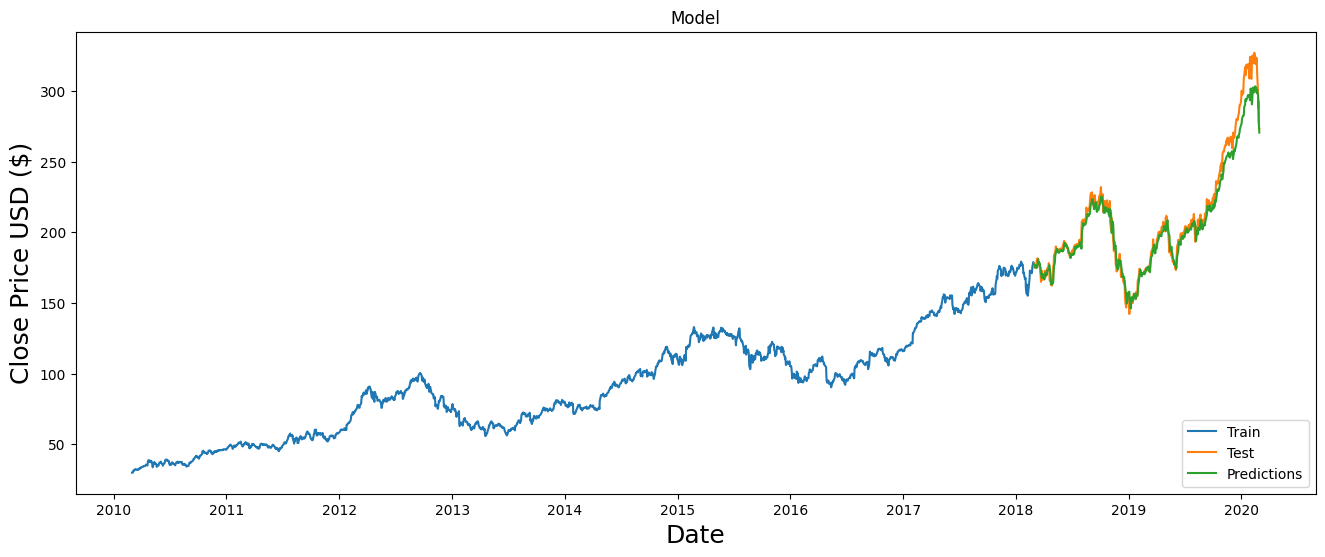

In [31]:
#Plot
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train[' Close/Last'])
plt.plot(valid[[' Close/Last', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

Interpretation:

- The plot comparing the actual and predicted stock prices shows that the model's predictions closely follow the trend of the actual closing prices in the test set.
- The small gap between the "Test" and "Predictions" lines indicates that the model captures the overall trend and seasonality in the data without significant deviation.

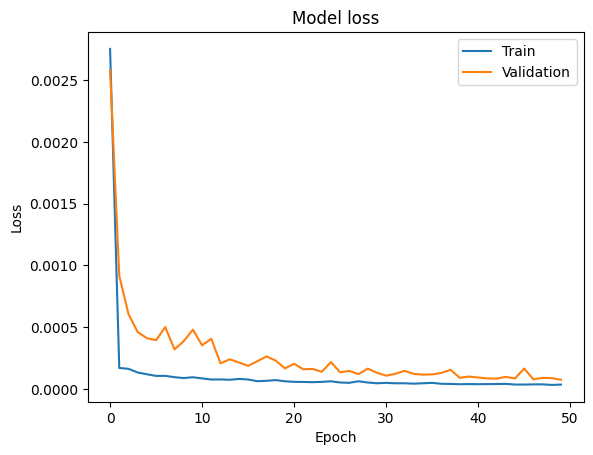

In [32]:
#Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Interpretation:

- The plot of training and validation loss values across epochs shows a steady decline, particularly in the early epochs, followed by stabilization at a low loss value.
- This suggests that the model is efficiently learning from the data and achieves an optimal balance between training and validation performance, confirming no overfitting issues.

# 6. Evaluation


In [33]:
# 6. Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 5.545682799324156
Root Mean Squared Error (RMSE): 8.007757655039326


Interpretation:

- Mean Absolute Error (MAE) of 5.55 suggests that, on average, the model's predictions are around $5.55 away from the actual values. This metric shows the magnitude of error in a way that's interpretable in the context of actual dollar amounts.
- Root Mean Squared Error (RMSE) of 8.01 indicates a relatively low level of error, as RMSE penalizes larger errors more than MAE does. Lower RMSE values imply that large prediction errors are rare, meaning the model is able to predict future stock prices with a good degree of accuracy.

Final Inference:

The model demonstrates strong performance with both low training and validation loss values, and its predictions align well with the actual stock prices. The low MAE and RMSE values indicate high predictive accuracy, making the model suitable for predicting stock price trends. The model captures the time-series pattern of stock prices effectively, and the stable validation loss indicates good generalization to unseen data. Overall, the model provides a reliable tool for predicting stock prices, with minor errors that could be acceptable in a financial forecasting context.